In [31]:
# Using PIPELINE: Built classification models to predict customer churn using logistic regression and XGBoost
# e.g. Customer-Churn.csv
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/customer-churn.csv")

# Clean TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0)

# Drop customerID
df.drop("customerID", axis=1, inplace=True)

# Encode target
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
y = df["Churn"]

# Define ordinal features (with a meaningful order)
ordinal_features = ["Contract"]
ordinal_mapping = [["Month-to-month", "One year", "Two year"]]  # low to high commitment

# All categorical features
cat_cols = df.select_dtypes(include="object").columns.tolist()

# Identify nominal (non-ordinal) features
nominal_features = [col for col in cat_cols if col not in ordinal_features]

# Numerical columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols.remove("Churn")

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("ord", OrdinalEncoder(categories=ordinal_mapping), ordinal_features),
        ("nom", OneHotEncoder(drop="first", handle_unknown="ignore"), nominal_features),
    ]
)

# Logistic Regression pipeline with feature selection
lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "feature_selection",
            SelectFromModel(
                LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
            ),
        ),
        ("classifier", LogisticRegression(max_iter=1000)),
    ]
)

# XGBoost pipeline (with same preprocessor and feature selection)
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "feature_selection",
            SelectFromModel(
                LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
            ),
        ),
        (
            "classifier",
            XGBClassifier(eval_metric="logloss", random_state=42),
        ),
    ]
)

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate Logistic Regression
lr_scores = cross_val_score(lr_pipeline, df, y, cv=cv, scoring="accuracy")

# Evaluate XGBoost
xgb_scores = cross_val_score(xgb_pipeline, df, y, cv=cv, scoring="accuracy")

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, stratify=y, random_state=42
)

xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)
y_prob = xgb_pipeline.predict_proba(X_test)[:, 1]

---
#### **`EDA Dashboards`**
---

##### **Target Distribution**

<Axes: title={'center': 'Churn Distribution'}, xlabel='Churn'>

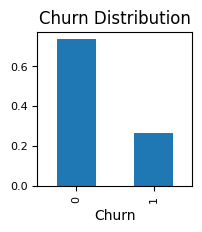

In [32]:
df["Churn"].value_counts(normalize=True).plot(
    kind="bar", title="Churn Distribution", figsize=(2, 2), fontsize=8
)

##### **Numerical Feature Histograms**

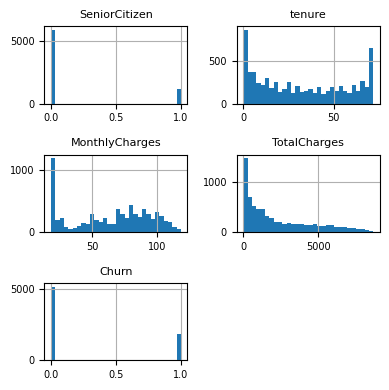

In [33]:
# Numerical columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
axes = df[num_cols].hist(bins=30, figsize=(4, 4), xlabelsize=7, ylabelsize=7)
# Loop through each subplot and set the title font size
for ax in axes.flatten():
    ax.title.set_fontsize(8)  # change 10 to whatever size you prefer
plt.tight_layout()
plt.show()

##### **Correlation Heatmap**

<Axes: >

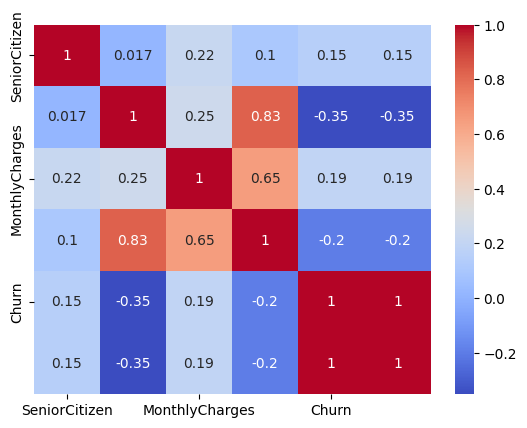

In [34]:
sns.heatmap(
    df[num_cols + ["Churn"]].corr(),
    annot=True,
    cmap="coolwarm",
    xticklabels=2,
    yticklabels=2,
)

##### **Churn vs Categorical Features (Bar plots)**

In [35]:
# for col in nominal_features + ordinal_features:
# pd.crosstab(df[col], df["Churn"], normalize="index").plot(kind="bar", stacked=True)
# plt.title(f"Churn Rate by {col}")
# plt.ylabel("Proportion")
# plt.show()

#### **📉 `Model Evaluation Dashboard`**

##### **ROC Curve (Receiver Operating Characteristic Curve)**
    - The ROC AUC(Area Under Curve) curve is a performance measurement for classification models, especially binary classifiers. 
    - It helps evaluate how well a model distinguishes between two classes (typically positive and negative).

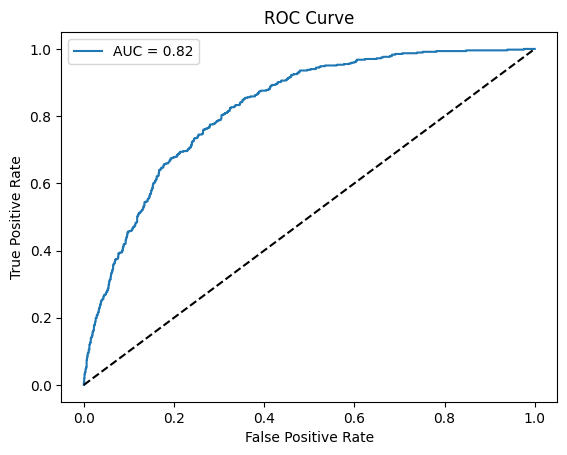

In [36]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

##### **Confusion Matrix**

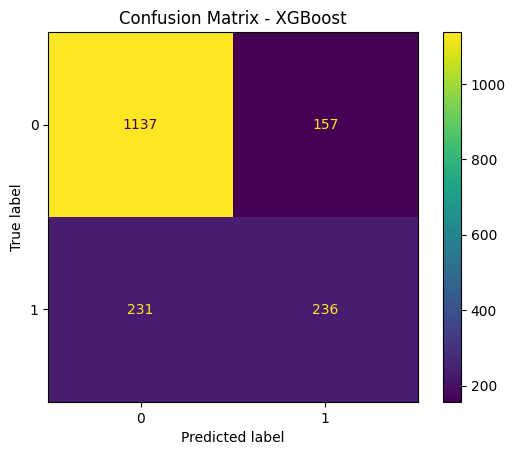

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(xgb_pipeline, X_test, y_test)
plt.title("Confusion Matrix - XGBoost")
plt.show()

##### **Feature Importance (from XGBoost)**

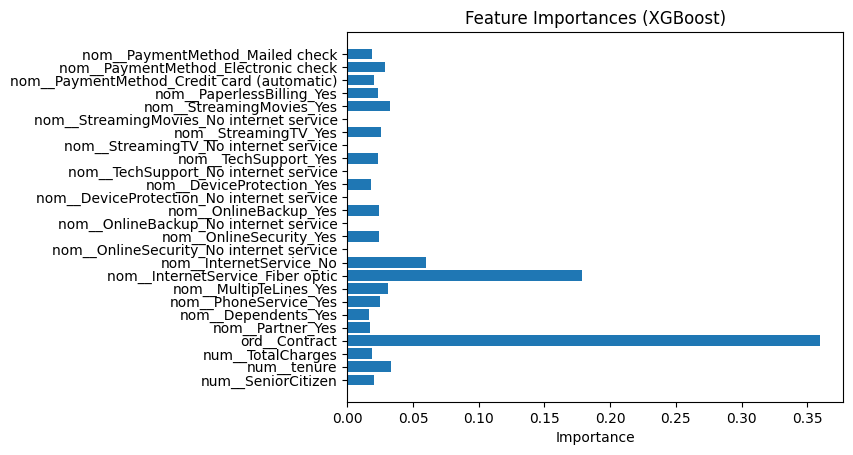

In [38]:
import matplotlib.pyplot as plt

xgb_model = xgb_pipeline.named_steps["classifier"]
importances = xgb_model.feature_importances_

# Get feature names from preprocessor
feature_names = xgb_pipeline.named_steps["preprocessor"].get_feature_names_out()
selected_features = xgb_pipeline.named_steps["feature_selection"].get_support()

# Map selected feature importances
selected_names = feature_names[selected_features]
plt.barh(selected_names, importances)
plt.title("Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()